# The best location for a new brewery in Toronto

## Introduction / Business Problem

According to research done here, https://www.brightlocal.com/research/local-business-travel-times/, people are willing to drive less distance to go to a specific pub/bar than any other business category besides the gym or yoga / alternative therapies. The location of a brewery is one of the biggest determinants if a brewery will get enough traffic to pay all of its expenses and eventually turn a profit. Breweries have become much more populor over the last handful of years and finding a location that still has plenty of demand can be tricky.  

Our objective is to recommend the best locations in Toronto to open a new brewery.  

## Data

Coordinate data of Toronto postal codes is in http://cocl.us/Geospatial_data.  The data base for Toronto postal code population and total private dwellings are from https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A.  

Accorindg to the research from Bright Local, on average, people are willing to drive about 14 minutes to a pub of their choice.  In a city, we will assume you can drive about 8 kilometers in 14 minutes.  Using the Foursquare API we will determine how many breweries are within a 8km radius of each postal code.  We will then use these numbers to determine the number of breweries per 5 mile radius there are for each postal code.  

We will generate a table with a number of rows corresponding to neighborhoods and columns with
- Postal Code
- longitude
- latitude
- population
- number of breweries within 5 mile radius
- breweries per capita

The neighborhood with the least amount of breweries per capita should tell us which neighborhoods have the most potential demand for a new brewery. 

## Methodology

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


#### Create a table of Toronto Neighborhoods & their coordinates

In [2]:
#grabbing table with Toronta neighborhoods and postal codes
table = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=1012023397')

In [3]:
df = table[0]

In [4]:
df.shape

(180, 3)

In [5]:
#dropping Boroughs with 'Not Assigned' as value
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)

In [6]:
df.shape

(103, 3)

In [7]:
#grabbing talbe of coordinates for toronta postal codes.
geo_df = pd.read_csv(r'C:\Users\rdhin\Documents\Python Scripts\Geospatial_Coordinates.csv')
geo_df.head()
print(geo_df.shape)

(103, 3)


In [8]:
#Combine df & geo_df into one df
df_hoods = df.set_index('Postal Code')
df_hoods.head()

,Borough,Neighbourhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [9]:
geo_df.set_index('Postal Code', inplace=True)
geo_df.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [10]:
df_grouped = pd.concat([df_hoods, geo_df], axis=1, join='inner')
df_grouped.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [11]:
df_grouped.index.name = 'PostalCode'
df_grouped.reset_index(inplace=True)

In [12]:
df_grouped.rename(columns = {'Neighbourhood': 'Neighborhood'}, inplace=True)
print(df_grouped.shape)
df_grouped.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Reducing the boroughs to only include those with Toronto in the name. 

In [13]:
toronto_boroughs = ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']
toronto_df = df_grouped[df_grouped['Borough'].isin(toronto_boroughs)].reset_index(drop=True)
print(toronto_df.shape)
toronto_df.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [14]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tl-toronto-neigh")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, long, post, borough, neigh in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['PostalCode'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


### Pull Brewery location data via FourSquare

Define Foursquare credentials and Version

In [15]:
CLIENT_ID = 'CYPYMD5I2YUJ05022RKNBJ0IMP0PMLCPCWWMCXOMKQAB2S2U' # your Foursquare ID
CLIENT_SECRET = 'S3LNEZXY2DBUJSZAL5TLLVNZZXB1CSUS2QWA45JZI2AHE0SR' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CYPYMD5I2YUJ05022RKNBJ0IMP0PMLCPCWWMCXOMKQAB2S2U
CLIENT_SECRET:S3LNEZXY2DBUJSZAL5TLLVNZZXB1CSUS2QWA45JZI2AHE0SR


Call Breweries within a 8km radius of each neighborhood into a df

In [16]:

# radius is in meters. 
radius = 8000
LIMIT = 100

venues = []

for lat, long, post, borough, neighboUrhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['PostalCode'], toronto_df['Borough'], toronto_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&query=brewery&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    

    results = requests.get(url).json()["response"]['groups'][0]['items']
    

    for venue in results:
        venues.append((
            post, 
            borough,
            neigh,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

venues_df = pd.DataFrame(venues)
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head()

(2006, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Steam Whistle Brewing,43.641752,-79.387089,Brewery
1,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Left Field Brewery,43.673705,-79.330310,Brewery
2,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Black Lab Brewing,43.661839,-79.329137,Brewery
3,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Bellwoods Brewery,43.647097,-79.419955,Brewery
4,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Eastbound Brewing Company,43.659008,-79.350250,Brewery


In [17]:
venues_df.groupby(['PostalCode', 'Borough', 'Neighborhood'])['VenueName'].count()

PostalCode  Borough           Neighborhood                                                                        
M4E         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    23
M4K         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    50
M4L         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    37
M4M         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    49
M4N         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    15
M4P         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    45
M4R         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    42
M4S         Central Toronto   Business

### Add population data to table with brewery data

In [18]:
# upload table with postal code population data
postal_pop = pd.read_csv(r'C:\Users\rdhin\Documents\Python Scripts\Torontoa_Postal_Code_Populations_M.csv', nrows=102)
postal_pop.head()

,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,01,Canada,NaN,T,35151728.0,15412443.0,14072079.0
1,M1K,M1K,Ontario,NaN,48434.0,18620.0,17930.0
2,M1L,M1L,Ontario,NaN,35081.0,12884.0,12428.0
3,M1M,M1M,Ontario,NaN,22913.0,8908.0,8623.0
4,M1N,M1N,Ontario,NaN,22136.0,9535.0,9095.0


In [19]:
#rename Geographic code to 'Postalcode' to match first table
postal_pop.rename(columns = {'Geographic code':'PostalCode'}, inplace = True)
postal_pop.head()

,PostalCode,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,01,Canada,NaN,T,35151728.0,15412443.0,14072079.0
1,M1K,M1K,Ontario,NaN,48434.0,18620.0,17930.0
2,M1L,M1L,Ontario,NaN,35081.0,12884.0,12428.0
3,M1M,M1M,Ontario,NaN,22913.0,8908.0,8623.0
4,M1N,M1N,Ontario,NaN,22136.0,9535.0,9095.0


In [20]:
#created new df to merge with postal_pop w/ PostalCode as index
postal_breweries = venues_df.groupby(['PostalCode', 'Borough', 'Neighborhood'])['VenueName'].count()
postal_breweries

PostalCode  Borough           Neighborhood                                                                        
M4E         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    23
M4K         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    50
M4L         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    37
M4M         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    49
M4N         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    15
M4P         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    45
M4R         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    42
M4S         Central Toronto   Business

In [21]:
#dropped unnecessary columns from postal_pop
postal_population = postal_pop.drop(columns = {'Geographic name', 'Province or territory', 'Incompletely enumerated Indian reserves and Indian settlements, 2016', 'Total private dwellings, 2016', 'Private dwellings occupied by usual residents, 2016'})
postal_population


,PostalCode,"Population, 2016"
0,01,35151728.0
1,M1K,48434.0
2,M1L,35081.0
3,M1M,22913.0
4,M1N,22136.0
5,M1P,45571.0
6,M1R,29858.0
7,M1S,37769.0
8,M1T,34588.0
9,M1V,54680.0


In [22]:
#dropping unecessary rows
postal_population.drop(index= [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,57,66,67,68,69,74,75,76,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101], axis =0, inplace=True)

postal_population

,PostalCode,"Population, 2016"
32,M4E,25044.0
36,M4K,31583.0
37,M4L,32640.0
38,M4M,24689.0
39,M4N,15330.0
40,M4P,20039.0
41,M4R,11394.0
42,M4S,26506.0
43,M4T,10463.0
44,M4V,18241.0


In [23]:
print(postal_population.shape)
print(postal_breweries.shape)

(39, 2)
(39,)


In [24]:
# Now joining the two dfs
Table = pd.merge(postal_breweries, postal_population, on='PostalCode', how='outer')
Table.rename(columns = {'VenueName':'Breweries in 8km radius'}, inplace = True)
Table.head()

,PostalCode,Breweries in 8km radius,"Population, 2016"
0,M4E,23,25044.0
1,M4K,50,31583.0
2,M4L,37,32640.0
3,M4M,49,24689.0
4,M4N,15,15330.0


In [25]:
#adding column to show breweries per capita
Table['Capita per Breweries']= Table['Population, 2016']/Table['Breweries in 8km radius']
Table.head()

,PostalCode,Breweries in 8km radius,"Population, 2016",Capita per Breweries
0,M4E,23,25044.0,1088.869565
1,M4K,50,31583.0,631.660000
2,M4L,37,32640.0,882.162162
3,M4M,49,24689.0,503.857143
4,M4N,15,15330.0,1022.000000


In [26]:
#adding coordinates to final table from geo_df
Table.set_index('PostalCode')

,Breweries in 8km radius,"Population, 2016",Capita per Breweries
PostalCode,,,
M4E,23,25044.0,1088.869565
M4K,50,31583.0,631.660000
M4L,37,32640.0,882.162162
M4M,49,24689.0,503.857143
M4N,15,15330.0,1022.000000
M4P,45,20039.0,445.311111
M4R,42,11394.0,271.285714
M4S,57,26506.0,465.017544
M4T,60,10463.0,174.383333


In [27]:
Table.rename(columns = {'PostalCode':'Postal Code'}, inplace = True)
Table.head()

,Postal Code,Breweries in 8km radius,"Population, 2016",Capita per Breweries
0,M4E,23,25044.0,1088.869565
1,M4K,50,31583.0,631.660000
2,M4L,37,32640.0,882.162162
3,M4M,49,24689.0,503.857143
4,M4N,15,15330.0,1022.000000


In [28]:
Table_Final = pd.merge(Table, geo_df, on='Postal Code', how='outer')

In [29]:
Table_Final.head()

,Postal Code,Breweries in 8km radius,"Population, 2016",Capita per Breweries,Latitude,Longitude
0,M4E,23.0,25044.0,1088.869565,43.676357,-79.293031
1,M4K,50.0,31583.0,631.660000,43.679557,-79.352188
2,M4L,37.0,32640.0,882.162162,43.668999,-79.315572
3,M4M,49.0,24689.0,503.857143,43.659526,-79.340923
4,M4N,15.0,15330.0,1022.000000,43.728020,-79.388790


In [35]:
# order table from lowest Breweries per capita to most
Table_Final.set_index('Postal Code')
Table_Final.sort_values('Capita per Breweries', inplace = True)
Table_Final.head(10)

,Postal Code,Breweries in 8km radius,"Population, 2016",Capita per Breweries,Latitude,Longitude
21,M5L,54.0,0.0,0.000000,43.648198,-79.379817
20,M5K,54.0,0.0,0.000000,43.647177,-79.381576
37,M7A,60.0,10.0,0.166667,43.662301,-79.389494
29,M5X,54.0,10.0,0.185185,43.648429,-79.382280
38,M7Y,36.0,10.0,0.277778,43.662744,-79.321558
28,M5W,53.0,15.0,0.283019,43.646435,-79.374846
18,M5H,57.0,2005.0,35.175439,43.650571,-79.384568
15,M5C,53.0,2951.0,55.679245,43.651494,-79.375418
17,M5G,58.0,8423.0,145.224138,43.657952,-79.387383
16,M5E,53.0,9118.0,172.037736,43.644771,-79.373306


Creating map of the top 10 spots

In [71]:
top_spots = Table_Final[:9]
top_spots

,Postal Code,Breweries in 8km radius,"Population, 2016",Capita per Breweries,Latitude,Longitude
21,M5L,54.0,0.0,0.000000,43.648198,-79.379817
20,M5K,54.0,0.0,0.000000,43.647177,-79.381576
37,M7A,60.0,10.0,0.166667,43.662301,-79.389494
29,M5X,54.0,10.0,0.185185,43.648429,-79.382280
38,M7Y,36.0,10.0,0.277778,43.662744,-79.321558
28,M5W,53.0,15.0,0.283019,43.646435,-79.374846
18,M5H,57.0,2005.0,35.175439,43.650571,-79.384568
15,M5C,53.0,2951.0,55.679245,43.651494,-79.375418
17,M5G,58.0,8423.0,145.224138,43.657952,-79.387383


In [72]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tl-toronto-neigh")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

map_top_loc = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, long, post in zip(top_spots['Latitude'], top_spots['Longitude'], top_spots['Postal Code']):
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_top_loc)
    
map_top_loc

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


Creating histogram of Capita per Breweries for all locations

In [60]:
import matplotlib.pyplot as plt

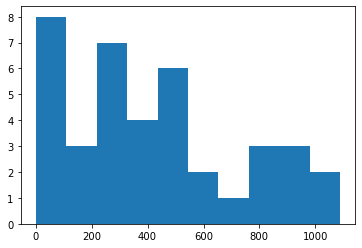

In [62]:
plt.hist(Table_Final['Capita per Breweries'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

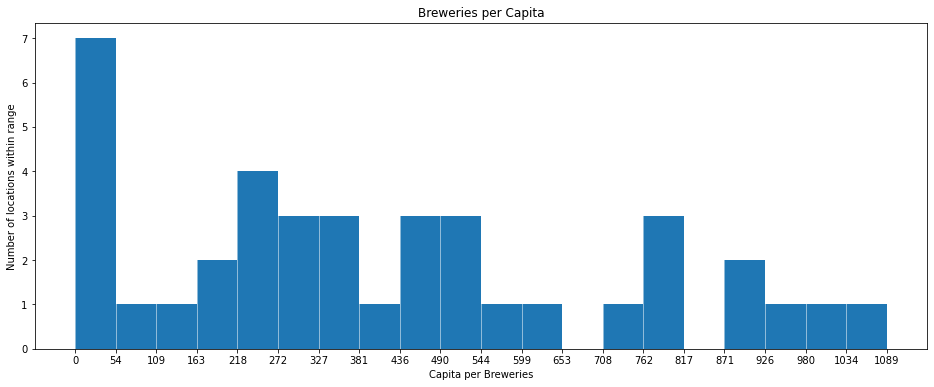

In [68]:
fig = plt.figure(figsize=(16,6))

n, bins, patches = plt.hist(Table_Final['Capita per Breweries'], bins =20)

plt.xticks(bins)
plt.grid(color='white', lw =.5, axis='x')
plt.title('Breweries per Capita')
plt.xlabel('Capita per Breweries')
plt.ylabel('Number of locations within range')
plt.show